# [AIA _ WHERE AM I 圖像分類](https://www.kaggle.com/c/aia-tc-image-cla-where-am-i/leaderboard "hello")

### 步驟：<br>
 1.定義問題<br>
 2.資料匯入<br>
 3.資料預處理<br>
 4.建立模型<br>
 5.進行訓練<br>
 6.進行預測<br>
 
## １.定義問題<br>
將各種不同類別的照片，分門別類將其放入15種不同的資料夾中。<br>

## ２.資料匯入

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import numpy as np
import glob
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt
datadir='//data/examples/may_the_4_be_with_u/where_am_i/'

### 將mid_term_mapping.txt的label讀入

In [2]:
labelmap=pd.read_csv(datadir+'mid_term_mapping.txt',names=['place','index'])

In [3]:
labelmap

,place,index
0,CALsuburb,9
1,PARoffice,7
2,bedroom,12
3,coast,10
4,forest,4
5,highway,14
6,industrial,2
7,insidecity,3
8,kitchen,0
9,livingroom,5


In [4]:
sortlabel=labelmap.sort('index')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


In [5]:
targetlist=sortlabel.place.as_matrix().tolist()

In [6]:
targetlist

['kitchen',
 'street',
 'industrial',
 'insidecity',
 'forest',
 'livingroom',
 'opencountry',
 'PARoffice',
 'mountain',
 'CALsuburb',
 'coast',
 'store',
 'bedroom',
 'tallbuilding',
 'highway']

## ３.資料預處理<br>
讀入照片檔

In [7]:
x=[]
y=[]
sz=32

for i,c in enumerate(targetlist):
    ff=glob.glob((datadir+'train/'+c+'/*jpg'))
    for f in ff:
        img=cv2.imread(f,0)
        img200=cv2.resize(img,(sz,sz))
        iii=(np.reshape(img200,(sz,sz,1))).astype(float)
        x.append(iii)
        nn=np.zeros(15,dtype=float) #One Hot
        nn[i]=1
        y.append(nn)
x_train=np.array(x)
y_label=np.array(y)

In [8]:
print(y_label[1])
len(y_label)

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


2985

In [9]:
x_train.shape

(2985, 32, 32, 1)

將x_train Normalization

In [10]:
x_train=x_train / 255.0
print(x_train[1][1][1])
len(x_train)

[ 0.5372549]


2985

將資料做測試集、驗證集的分割

In [11]:
random_seed  = 2 #用random_seed來做作隨機分割
x_train, x_valid, y_label, y_valid = train_test_split(x_train, 
                                                      y_label, 
                                                      test_size = 0.1, random_state=random_seed)

print("training set data dimension")
print(x_train.shape)
print(y_label.shape)
print("-----------")
print("training set: %i" % len(x_train))
print("validation set: %i" % len(x_valid))

training set data dimension
(2686, 32, 32, 1)
(2686, 15)
-----------
training set: 2686
validation set: 299


In [12]:
print("train data:",'images:',x_train.shape,
      " labels:",y_label.shape)
print("valid data:",'images:',x_valid.shape ,
      " labels:",y_valid.shape)

train data: images: (2686, 32, 32, 1)  labels: (2686, 15)
valid data: images: (299, 32, 32, 1)  labels: (299, 15)


## ４.建立模型
這次我利用keras卷積神經網路(CNN)來當我的模型。<br><br>
![CNN](http://html.rhhz.net/CHXB/html/PIC/chxb-45-9-1073-4.jpg)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

Using TensorFlow backend.


建立keras的Sequential模型

In [14]:
model = Sequential()

建立卷積層1與池化層1

In [15]:
model.add(Conv2D(filters=32,kernel_size=(3,3),
                 input_shape=(sz, sz,1),
                 activation='relu',
                 padding='same'))
model.add(Dropout(rate=0.3)) #Dropout避免Overfitting
model.add(Conv2D(filters=32,kernel_size=(3,3), #後續多增加一次Conv2D層
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2,2))) #池化層

建立卷積層2與池化層2

In [16]:
model.add(Conv2D(filters=64,kernel_size=(3,3),
                 activation='relu',
                 padding='same'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(filters=64,kernel_size=(3,3),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

建立卷積層3與池化層3

In [17]:
model.add(Conv2D(filters=128, kernel_size=(3, 3),
                activation='relu', padding='same'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(filters=128, kernel_size=(3, 3),
                activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

建立神經網路(平坦層、隱藏層、輸出層)

In [18]:
model.add(Flatten())
model.add(Dropout(rate=0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(15, activation='softmax'))

In [19]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
__________

# ５.進行訓練

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [21]:
train_history=model.fit(x_train, y_label,
                        validation_split=0.2,
                        epochs=100, batch_size=32, verbose=1) #進行一百次訓練，因為batch_size設定32，所以不用花到太多時間

Train on 2148 samples, validate on 538 samples
Epoch 1/100
2148/2148 [==============================] - 3s 2ms/step - loss: 2.6807 - acc: 0.0992 - val_loss: 2.6658 - val_acc: 0.0985
Epoch 2/100
2148/2148 [==============================] - 1s 404us/step - loss: 2.6284 - acc: 0.1164 - val_loss: 2.5647 - val_acc: 0.1729
Epoch 3/100
2148/2148 [==============================] - 1s 450us/step - loss: 2.4176 - acc: 0.2123 - val_loss: 2.4681 - val_acc: 0.1896
Epoch 4/100
2148/2148 [==============================] - 1s 430us/step - loss: 2.0911 - acc: 0.3031 - val_loss: 2.0327 - val_acc: 0.3327
Epoch 5/100
2148/2148 [==============================] - 1s 417us/step - loss: 1.8842 - acc: 0.3524 - val_loss: 2.0208 - val_acc: 0.3011
Epoch 6/100
2148/2148 [==============================] - 1s 428us/step - loss: 1.7209 - acc: 0.4171 - val_loss: 1.7965 - val_acc: 0.3662
Epoch 7/100
2148/2148 [==============================] - 1s 434us/step - loss: 1.6077 - acc: 0.4413 - val_loss: 1.9380 - val_acc: 0.4

In [22]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

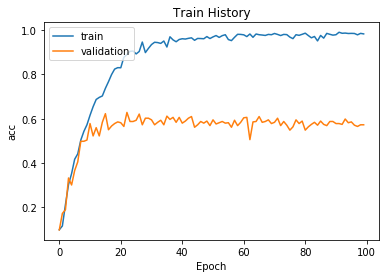

In [23]:
show_train_history(train_history,'acc','val_acc')

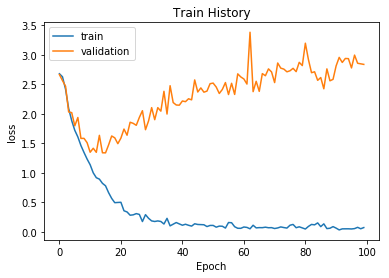

In [24]:
show_train_history(train_history,'loss','val_loss')

評估模型準確率

In [25]:
scores = model.evaluate(x_train,
                        y_label, verbose=0)
scores[1]

0.9110201042442293

匯入測試資料

In [26]:
testdata=pd.read_csv(datadir+'img-submission.csv')

In [27]:
testdata

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,1
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,1
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...,1
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1...,1
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06d...,1
5,f80823d6bff6c0beba6d55a3157d7a4fa2de4f966351e0...,1
6,3a12151639cf9f8e2af9ea36c2ce6bb15dd8730ea6dc90...,1
7,a5e0980425df5b98864a9580e081a7209e1b6810ed515a...,1
8,d4ea833073c4391387bebaef3c51c22861c1ff108cbb3c...,1
9,013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...,1


In [28]:
testdataindexlist=testdata.id.as_matrix().tolist()

In [29]:
x_t=[]



for f in testdataindexlist:
    img=cv2.imread(datadir+'testset/'+f+'.jpg',0)
    img200=cv2.resize(img,(sz,sz))
    iii=(np.reshape(img200,(sz,sz,1))).astype(float)
    x_t.append(iii)

        
x_test=np.array(x_t)

In [30]:
x_test.shape

(1500, 32, 32, 1)

In [31]:
x_test = x_test / 255.0 #Normalization

## ６.進行預測

In [32]:
predict=model.predict_classes(x_test)

In [33]:
predict

array([ 2, 10,  0, ..., 13,  5,  8])

In [34]:
testdata.id.count()

1500

將預測資料label匯入testdata

In [35]:
#sss=testdata.id.count()
#print(sss)
for j in range(0,len(x_test)-1):
    testdata['class'][j] = predict[j]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [36]:
testdata

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4...,2
1,96baacc2e97886a998807ce197574821a6dc83c227c746...,10
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d...,0
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1...,7
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06d...,0
5,f80823d6bff6c0beba6d55a3157d7a4fa2de4f966351e0...,13
6,3a12151639cf9f8e2af9ea36c2ce6bb15dd8730ea6dc90...,13
7,a5e0980425df5b98864a9580e081a7209e1b6810ed515a...,10
8,d4ea833073c4391387bebaef3c51c22861c1ff108cbb3c...,11
9,013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...,8


匯出結果

In [37]:
testdata.to_csv('ans.csv', index=False)